<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

## Exercise Set 3, Exercise 2, What Gets Neurons Excited?
In this notebook you will study what features of an image lead to a large activation of a particular unit in an intermediate layer of a convolutional neural network.

<img src="exciting-patches.png" style="width:500px"/>
Above image shows five examples of patches of the example images that maximized the values of five different neurons of an intermediate layer.
This analysis is important  

  * to obtain an intuition how CNNs achieve their performance and
  * for *transfer learning*, where the *output of an intermediate layer* is used as an *input* to another neural network.
  
With transfer learning, you can leverage a pre-trained publicly availabe model that was trained for one purpse, e.g. general purpose image classification, to your specific problem, e.g. distinguishing between photos of your own family members.

**Instructions:**

  1. Read through the expanded cells (not minimized with three dots).
  2. Currently, the final image, that is supposed to answer the title question, is wrong! Go to the cell with "**Exercise**" and chose the vales of question  correctly. After reexecution of the remainer, the final image should then largely show image patches that are i) useful for discrimination by humans, too (like above examples) and ii) be fairly homogeneous for each channel ( = square of 16 image patches).

In [1]:
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load a Pretrained Image Classification CNN (Cats, Dogs, Wolves, Plants)

In [2]:
# load the model from the drive
frozen_model = tf.keras.models.load_model('animals_and_plants-frozen.h5')

W0923 16:58:30.626130 140310446131008 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Image Data Preparation - Make Data Frames
We will create Pandas data frames to hold the file names and class labels.

In [3]:
# directory with image class subdirectories
img_path = '../data/cats-dogs-plants'

# Create a pandas dataframe from a tab separated file 
df = pd.read_csv(img_path + "/classes-and-fnames.txt", sep = '\t', names = ['classname', 'fname'])
df['path'] = img_path + '/' + df['classname'] + "/" + df['fname']

# take only a sample to reduce memory consumption on brain during class
# reduce this further if you get an error "Out of memory"
df = df.sample(4000)

## Make TensorFlow Datasets

In [4]:
img_size = 96           # width and height of all images (resize, if required)
num_imgs  = df.shape[0] # total number of examples
print("number of images:", num_imgs)

number of images: 4000


### Make tf.Dataset

In [5]:
def path_to_array(filename):
    """ Map a filename to an actual image tensor using image augmentation, one-hot encode label."""
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, [img_size, img_size]) / 255.
    return img

In [6]:
# Make a tf dataset of images from a pd data frame of file paths
# first, make dataset with just the path string
ds_path = tf.data.Dataset.from_tensor_slices(df['path'])

# convert to data set with actual images
ds = ds_path.map(path_to_array)

In [7]:
# obtain all images as a single tensor x
x = None
for x_ in ds.batch(num_imgs): # make a fake loop with one iteration as tf.Dataset's apparently have not function for that
    x = x_.numpy()
    break
    
print(x.shape)

(4000, 96, 96, 3)


In [8]:
# Delete large unneccessary variables as the code below needs a lot of memory and we only need x.
del ds, df

### Make a model that outputs intermediate layer's activations from ```frozen_model```
First read in the model and let's assume we didn't know the model architecture (it is from ```cnn-class-cats.ipynb```).

In [9]:
# print out a summary of the model ...
frozen_model.summary()

# ... as well as details on the kernel sizes and strides
print("Conv2d and MaxPool2Dlayers:\nlayer num, name, kernel size and strides")
formatstr = "{:>2d}  {:16s} {:10s} {:10}"
for i, layer in enumerate(frozen_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(formatstr.format(i, layer.name, str(layer.kernel_size), str(layer.strides)))
    if isinstance(layer, tf.keras.layers.MaxPool2D):
        print(formatstr.format(i, layer.name, "  -", str(layer.strides)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        1

### Chose a target layer and create a model that computes its activation ("feature map")

In [10]:
# we here chose the output of the 6th convolutional layer
target_layer_name = "conv2d_5"

# create feature map: a function that maps an image to the activation (value) of the target layer's units
layer_output = frozen_model.get_layer(target_layer_name).output
feature_map = tf.keras.models.Model(inputs = frozen_model.input, outputs = layer_output)

Compute the activation for the ~7000 images

In [11]:
layer_act = feature_map.predict(x) # takes ~1m
layer_shape = layer_act.shape
layer_shape

(4000, 39, 39, 64)

## What gets neurons excited?
Each of the 64 channels $c$ of the target layer activation contains output of a function that maps square image patches from the input to the value of an activation in channel $c$ of the target layer. To see what kind of input leads to a large activation, we simply go through all such patches from all our images and take note the ones that produced the highest activations. Frequently, when a square image patch "excites" a neuron, neighboring image patches that largely overlap the firs also exite that neuron. To obtain independent results, we allow *at most one* such patch per image.

In [12]:
# set the number to example image patches to see per channel
k_root = 4
k = k_root**2 # find the k most activating image patches, chosen as a square for better visialization

In [13]:
# first maximize over the width and height of the layer
# move these two dimensions to the front, then flatten them to one dimension
T = layer_act.transpose((1, 2, 0, 3)).reshape([-1, layer_shape[0], layer_shape[3]])
print("T", T.shape)

# find the "image" coordinates, that maximize activation
# for each photo and channel of the target layer
img_flat_ind = np.argmax(T, axis = 0)
R = np.max(T, axis = 0)
print("R", R.shape, "\nimg_flat_ind", img_flat_ind.shape)

# efficiently (linear time) find the k images with the largest maximal activations 
bb = np.argpartition(R, -k, axis = 0)[-k:] # for each channel: which k images have the highest activating patches?
print("indices to image bb", bb.shape)

# now get the row (i) and col (j) coordinates of the k best images for each channel
S = np.zeros_like(bb)
for c in range(S.shape[1]): # loop over channels
    subset = bb[:, c]
    S[:, c] = img_flat_ind[subset, c] # use fancy indexing
print("S", S.shape)

# map indices from the flattened array back to image coordinate pairs
ii, jj = np.unravel_index(S, layer_shape[1:3]) 
print ("indices to row ii ", ii.shape)

del T, img_flat_ind, R, S, layer_act # let the kernel free the memory

T (1521, 4000, 64)
R (4000, 64) 
img_flat_ind (4000, 64)
indices to image bb (16, 64)
S (16, 64)
indices to row ii  (16, 64)


 ### Determine the origin patches position and size for any unit in the intermediate layer
 
 <img size="1900" src="es3-ex2-sol1.png"/>
 
 **Exercise:** Figure this out with pen and scratch paper and then enter the correct numbers manually below.

In [14]:
# ur_size is the height and width of a square patch of the original image
# that a single unit of layer conv2d_5 (shape: 39, 39, 64) depends on, say ur-patch
ur_size = 15 # YOUR VALUE HERE

# If you shift one unit to the right (or left) in layer conv2d_5, the upper left corner of the ur-patch shifts by scaling_factor units to the right (left)
scaling_factor = 1 # YOUR VALUE HERE

### Plot the maximizing image patches for each channel
Below plot shows the $k=16$ best fitting images for each channel of the first ```2 * num_fig_rows``` channels of the 8-th layer (```conv2d_5```). What do they appear to recognize? Remember, that a single unit in a convolutional layer gets input from **all channels** of the previous layer.

**WARNING: Until the exercise is solved, below images are wrong and fairly random!**

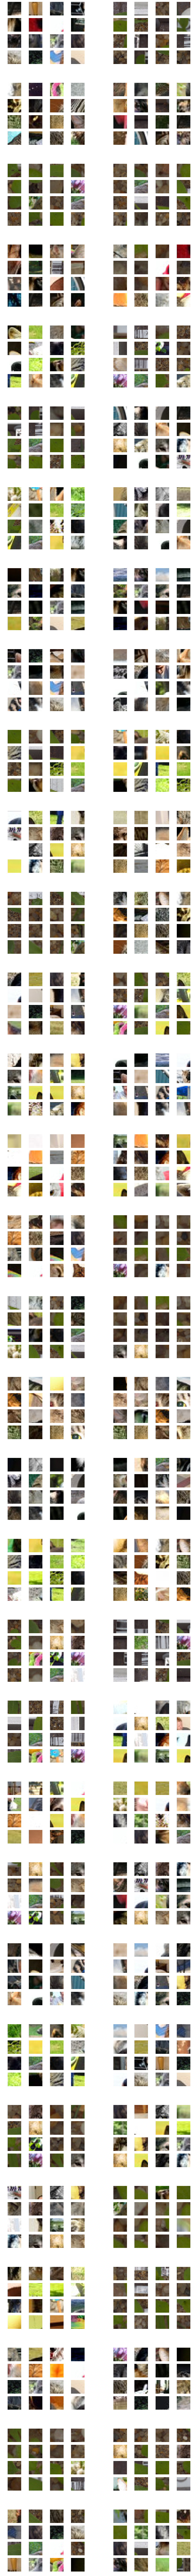

In [15]:
num_fig_rows = 32 # must be below 32 = layer_shape[3] / 2

# plot_feature_map
# display the patches for 2 channels in one figure "row"
fig, ax = plt.subplots(nrows = num_fig_rows * (k_root + 1) - 1, ncols = 2 * k_root + 1, figsize = (18, num_fig_rows * 8 - 2))
[axi.set_axis_off() for axi in ax.ravel()]
for c in range(2 * num_fig_rows):
    irow_offset = math.floor(c / 2)  * (k_root + 1)
    icol_offset = (c % 2) * (k_root + 1)
    for r in range(k):
        irow = math.floor(r / k_root) + irow_offset
        icol = r % k_root + icol_offset
        
        # scaling_factor used here to find the coordinates (i, j) of the upper left corner of the ur-patch
        i = scaling_factor * ii[r, c]
        j = scaling_factor * jj[r, c] 
        
        # ur_size used here to find the coordinates of the lower right (lr) pixel of the ur-patch
        lr_i = i + ur_size
        lr_j = j + ur_size
        
        if (i >= 0 and lr_i <= img_size and j >= 0 and lr_j <= img_size):
            img = x[bb[r, c], i : lr_i, j : lr_j, :]
            ax[irow, icol].imshow(img)